<a href="https://colab.research.google.com/github/TY-2009/Pneumonia-Detection/blob/main/Pneumonia_Detection_3_Completed_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import random

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D, Input
from keras.regularizers import l2
import tensorflow.keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121

from imgaug import augmenters
def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)

def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = scale)
  return augment(data, fun)

def flip_left_right(data, prob):
  fun = augmenters.Fliplr(p = prob)
  return augment(data, fun)

def flip_up_down(data, prob):
  fun = augmenters.Flipud(p = prob)
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    field_data, field_labels = get_data_split('field', flatten, all_data, metadata, image_shape)
    field_data[:,:,:,2] = field_data[:,:,:,0]
    field_data[:,:,:,1] = field_data[:,:,:,0]

    #make data messier
    rand = random.uniform(-1, 1)

    for i in range(len(field_data)):
      image = field_data[i]

      if abs(rand) < 0.5:
        image = rotate(image, rotate = rand * 40)
      elif abs(rand) < 0.8:
        image = shear(image, shear = rand*40)
      field_data[i] = image
    return field_data, field_labels

class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  #### QUERYING AND COMBINING DATA
  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 4)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params):
    model = Sequential()

    model.add(Input(nn_params['input_shape']))
    model.add(Flatten())
    model.add(Dropout(0.5))

    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      model.add(Dropout(0.5))

    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=keras.optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params):
    model = Sequential()

    model.add(Input(nn_params['input_shape']))
    model.add(Conv2D(32, (3, 3), padding = 'same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers - 1):
        model.add(Conv2D(64, (3, 3), padding = 'same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 64, activation = 'relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(learning_rate=1e-5)

    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

  def TransferClassifier(name, nn_params, trainable = False):
    expert_dict = {'VGG16' : VGG16,
                   'VGG19' : VGG19,
                   'ResNet50' : ResNet50,
                   'DenseNet121' : DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet',
                                              include_top = False,
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable

    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    # expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))
    # expert_model.add(Dropout(0.3))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'],
                  optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
                  metrics=['accuracy'])

    return expert_model

### defining project variables
# file variables
metadata_url         = "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
image_data_url       = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy"


### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.keras', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

metadata.csv.1      100%[===================>]  39.56K  --.-KB/s    in 0.03s   
image_data.npy.1    100%[===================>] 131.25M  31.0MB/s    in 5.1s    


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 237ms/step - accuracy: 0.5102 - loss: 2.0245 - val_accuracy: 0.6550 - val_loss: 1.9990
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.5993 - loss: 1.9941 - val_accuracy: 0.7225 - val_loss: 1.9750
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - accuracy: 0.6293 - loss: 1.9676 - val_accuracy: 0.8100 - val_loss: 1.9476
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.6962 - loss: 1.9370 - val_accuracy: 0.8025 - val_loss: 1.9211
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.7222 - loss: 1.9107 - val_accuracy: 0.8150 - val_loss: 1.8925
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 229ms/step - accuracy: 0.7624 - loss: 1.8746 - val_accuracy: 0.7700 - val_loss: 1.8682
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 294ms/step - accuracy: 0.7637 - loss: 1.8533 - val_accuracy: 0.7750 - val_loss: 1.8419
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - accuracy: 0.7893 - loss: 1.8198 - val_accu

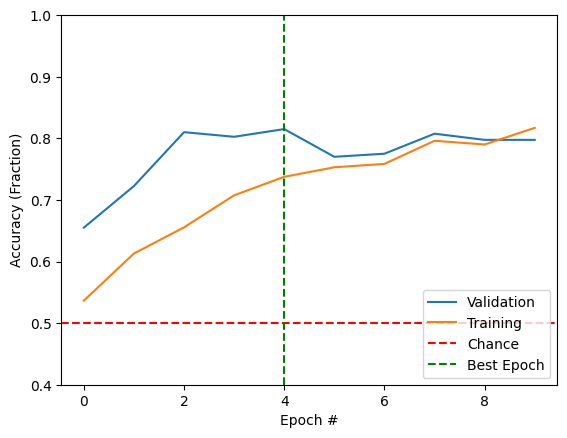

In [9]:
X_train, y_train = get_train_data()
X_test, y_test   = get_test_data()

cnn = CNNClassifier(2)
cnn_history = cnn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=True, callbacks=[monitor])
plot_acc(cnn_history)

In [10]:
X_field, y_field = get_field_data()

In [11]:
y_pred = (cnn.predict(X_field) > 0.5)
accuracy_score(y_field, y_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


0.7025

In [12]:
number_of_runs = 5
accuracy_total = 0

for i in range(number_of_runs):
  cnn_temp = CNNClassifier(5)
  cnn_temp.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), shuffle=True, callbacks=[monitor])

  y_pred = (cnn_temp.predict(X_field) > 0.5)

  accuracy = accuracy_score(y_field, y_pred)
  print('Accuracy on this run:', accuracy)
  accuracy_total += accuracy

print('Average accuracy:', accuracy_total / number_of_runs)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 279ms/step - accuracy: 0.5033 - loss: 3.9285 - val_accuracy: 0.5000 - val_loss: 3.8807
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 263ms/step - accuracy: 0.4791 - loss: 3.8668 - val_accuracy: 0.5000 - val_loss: 3.8201
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 294ms/step - accuracy: 0.5209 - loss: 3.8045 - val_accuracy: 0.5025 - val_loss: 3.7604
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 290ms/step - accuracy: 0.5136 - loss: 3.7461 - val_accuracy: 0.5100 - val_loss: 3.7016
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 286ms/step - accuracy: 0.4742 - loss: 3.6883 - val_accuracy: 0.6150 - val_loss: 3.6434
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy on this run: 0.5725
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step - accuracy: 0.4981 - loss: 3.9185 - val_accuracy: 0.5000 - val_loss: 3.8728
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 348ms/step - accuracy: 0.5202 - loss: 3.8578 - val_accuracy: 0.5000 - val_loss: 3.8148
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━

FIELD data:
Label: 1.0


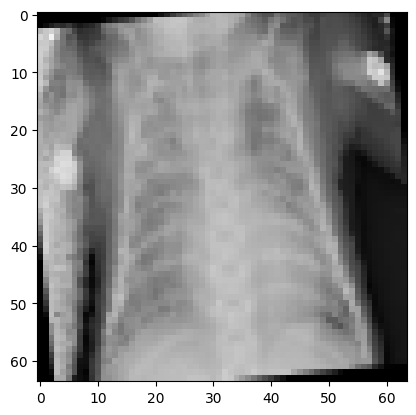

Label: 1.0


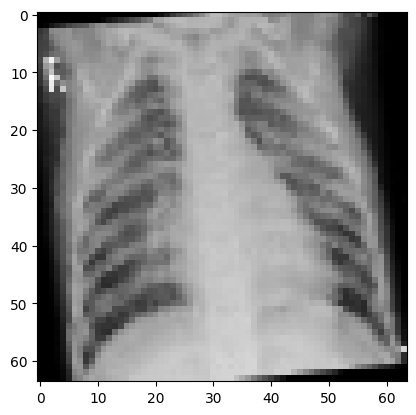

Label: 0.0


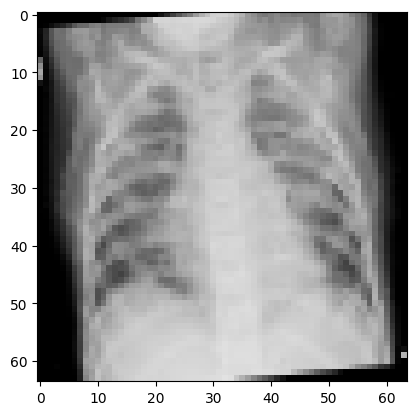

Label: 0.0


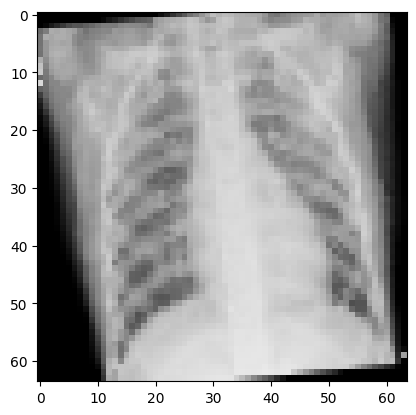

Label: 0.0


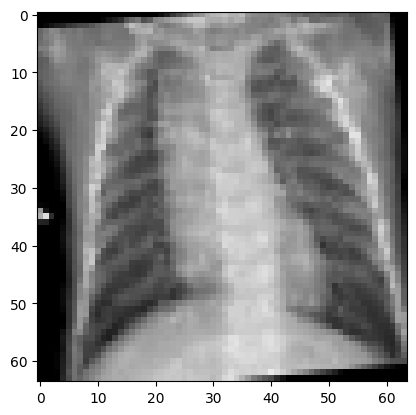

Label: 1.0


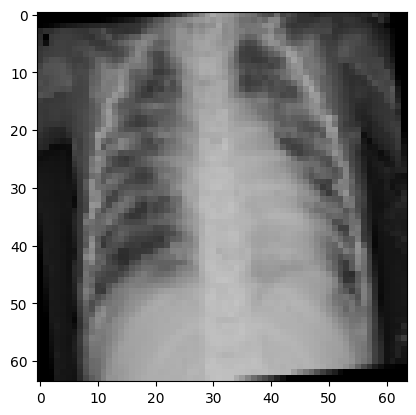

Label: 0.0


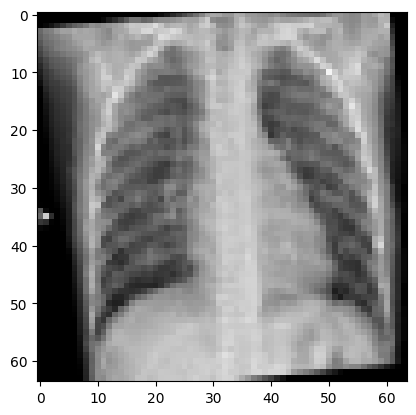

Label: 1.0


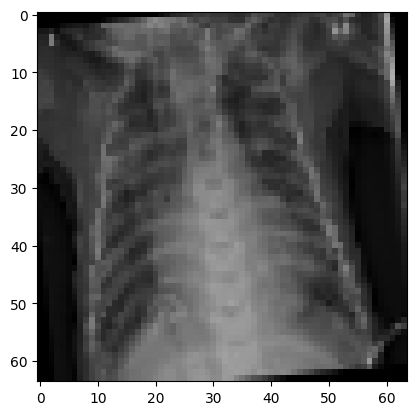

Label: 0.0


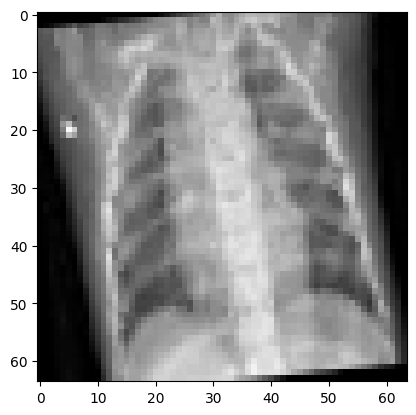

Label: 0.0


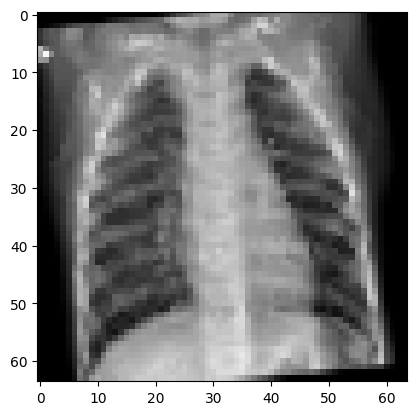

TRAIN data:
Label: 0.0


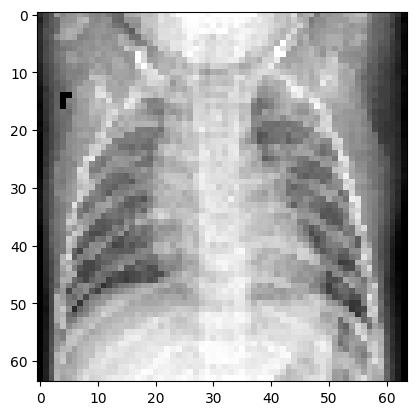

Label: 0.0


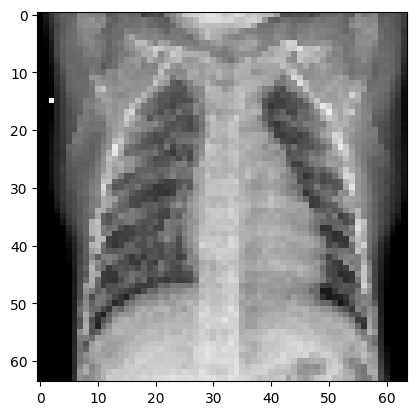

Label: 1.0


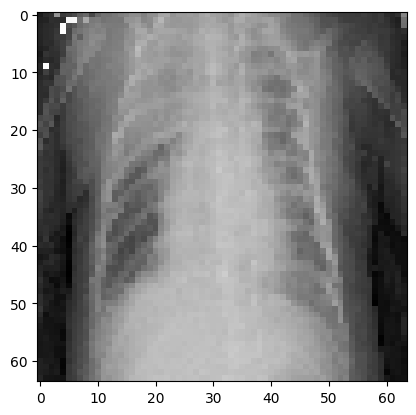

Label: 0.0


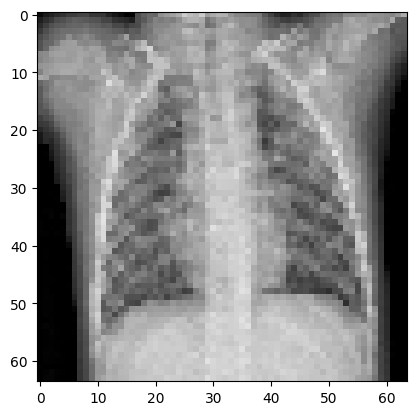

Label: 1.0


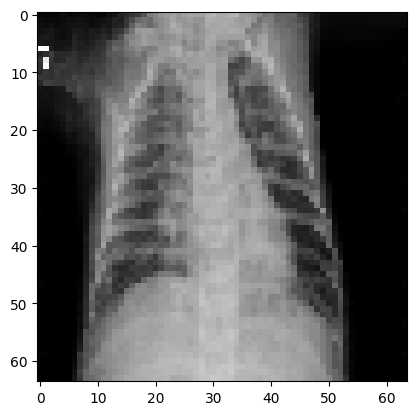

Label: 1.0


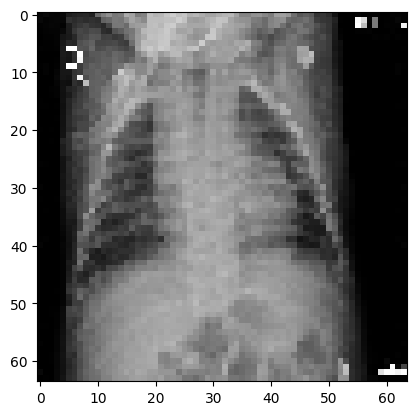

Label: 1.0


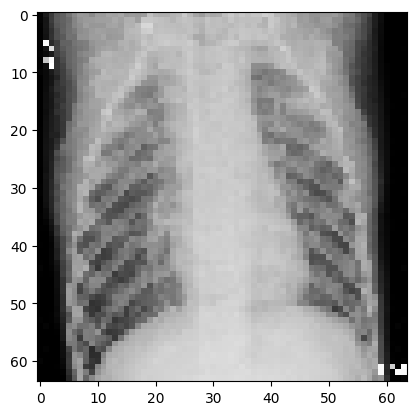

Label: 0.0


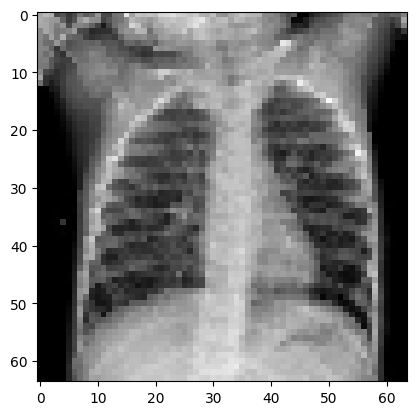

Label: 1.0


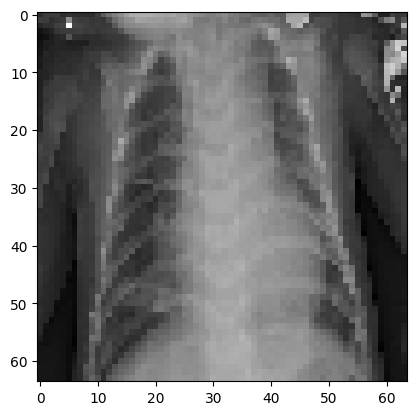

Label: 1.0


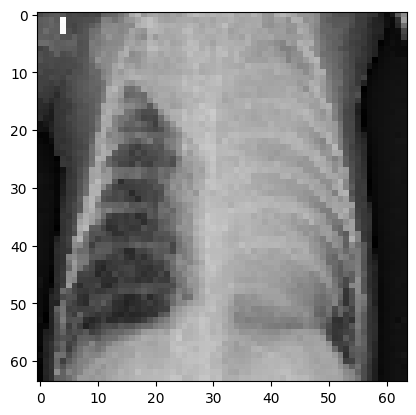

TEST data:
Label: 1.0


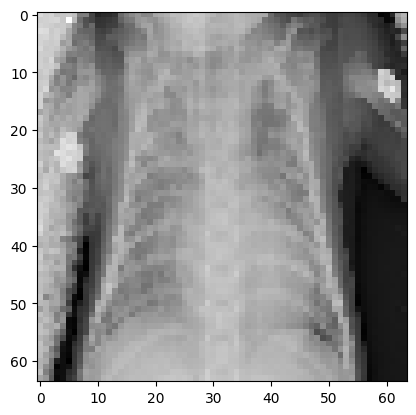

Label: 1.0


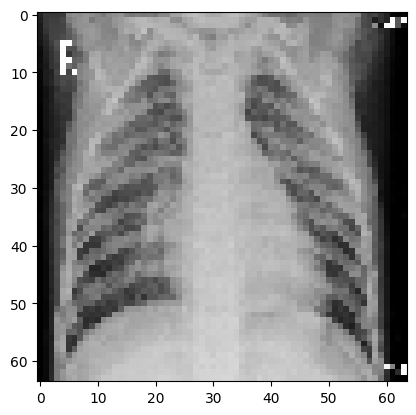

Label: 0.0


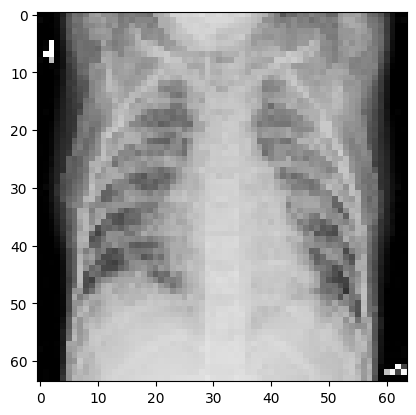

Label: 0.0


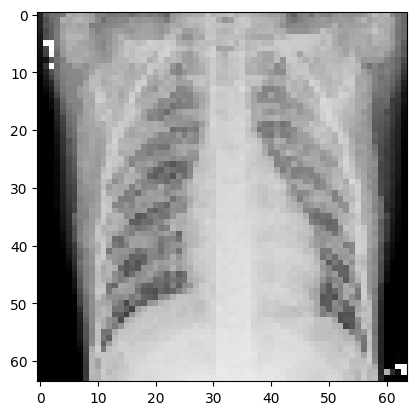

Label: 0.0


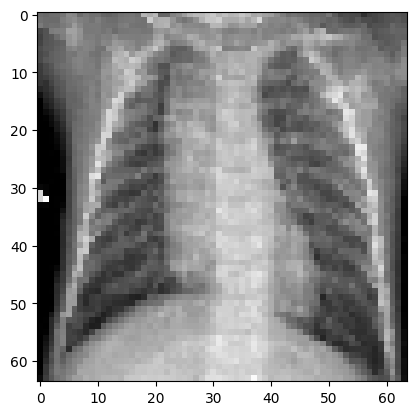

Label: 1.0


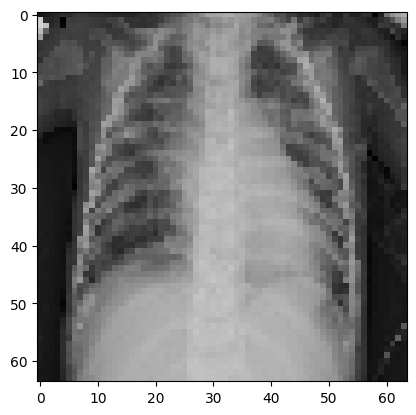

Label: 0.0


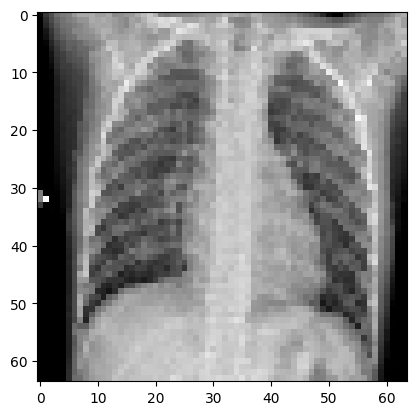

Label: 1.0


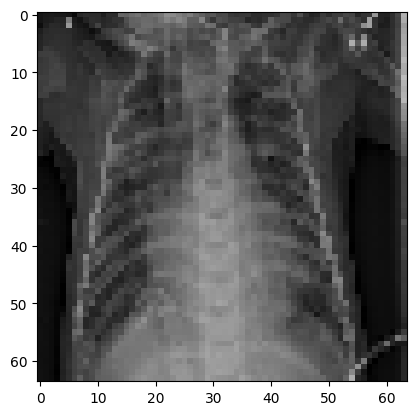

Label: 0.0


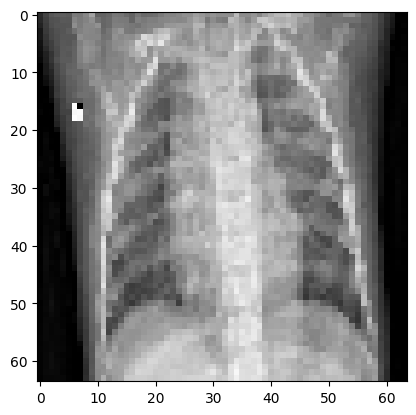

Label: 0.0


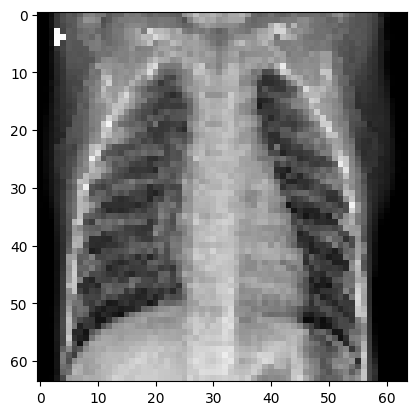

In [13]:
print ("FIELD data:")
for i in range(10):
  plot_one_image(X_field, y_field, i)

print ("TRAIN data:")
for i in range(10):
  plot_one_image(X_train, y_train, i)

print ("TEST data:")
for i in range(10):
  plot_one_image(X_test, y_test, i)

Label: 


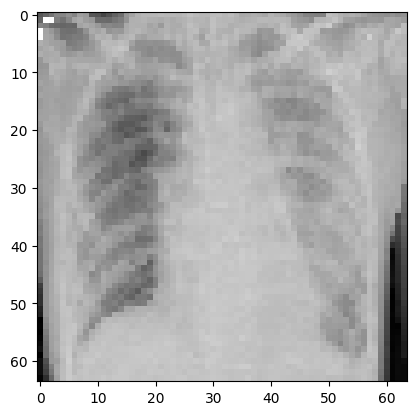

Label: 


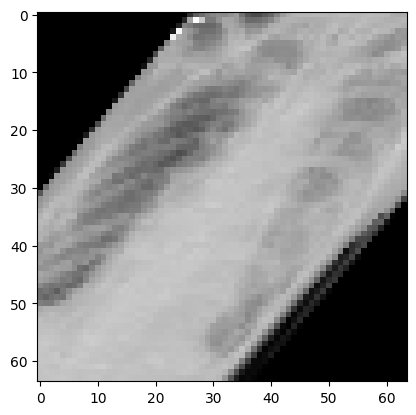

In [14]:
image = X_train[30]
plot_one_image(image)
new_image = shear(image, 40)
plot_one_image(new_image)

In [15]:
train_data_rotated_10 = rotate(X_train, rotate=10)
train_data_rotated_180 = rotate(X_train, rotate=180)
train_data_rotated_270 = rotate(X_train, rotate=270)
red_train = remove_color(remove_color(X_train, channel = 1), channel = 2)

In [16]:
all_data, all_labels = combine_data([X_train, train_data_rotated_10, train_data_rotated_180, train_data_rotated_270, red_train], \
                                    [y_train, y_train, y_train, y_train, y_train,])

In [17]:
number_of_runs = 5
accuracy_total = 0

for i in range(5):
  cnn = CNNClassifier(2)
  cnn.fit(all_data, all_labels, epochs=5, validation_data=(X_test, y_test), shuffle=True, callbacks=[monitor])
  predictions = (cnn.predict(X_field) > 0.5)

  accuracy = accuracy_score(y_field, predictions)
  print('Accuracy:', accuracy)
  accuracy_total += accuracy

average_accuracy = accuracy_total / number_of_runs

print('Average accuracy: ', average_accuracy)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 220ms/step - accuracy: 0.5424 - loss: 2.0040 - val_accuracy: 0.7225 - val_loss: 1.9090
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 217ms/step - accuracy: 0.6516 - loss: 1.8995 - val_accuracy: 0.8225 - val_loss: 1.7895
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 65s 209ms/step - accuracy: 0.7206 - loss: 1.7944 - val_accuracy: 0.8475 - val_loss: 1.6721
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 65s 207ms/step - accuracy: 0.7761 - loss: 1.6862 - val_accuracy: 0.8450 - val_loss: 1.5615
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 207ms/step - accuracy: 0.8080 - loss: 1.5904 - val_accuracy: 0.8475 - val_loss: 1.4632
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Accuracy: 0.7875
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 212ms/step - accuracy: 0.5277 - loss: 1.9983 - val_accuracy: 0.7025 - val_loss: 1.9117
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 226ms/step - accuracy: 0.6388 - loss: 1.8961 - val_accuracy: 0.8425 - val_loss: 1.7977
Epoch 3/5
313/313 ━━━━━━━━━━━━━━

In [18]:
import shutil
from google.colab import drive, files

file_name = "cnn_model_pneumonia_detection.keras" #@param {"type":"string"}
cnn.save(file_name)


download_to_Google_Drive = True

if download_to_Google_Drive:
    drive.mount('/content/drive')
    shutil.copy(file_name, '/content/drive/My Drive/')
else:
    files.download(file_name)

Mounted at /content/drive


In [1]:
!fusermount -u /content/drive


fusermount: failed to unmount /content/drive: No such file or directory
